# LIBRARIES
---

In [ ]:
!pip install mlflow xgboost pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.2/676.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 11.6 MB/s eta 0:00:00


In [ ]:
import os, mlflow
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score
from IPython.display import display

In [ ]:
command = """
mlflow server \
        --backend-store-uri sqlite:///tracking.db \
        --default-artifact-root file:mlruns \
        -p 5000 &
"""
get_ipython().system_raw(command)

In [ ]:
token = "2zIRmntYYlVitoKQtZOCwxGtt95_7GiBiaEhS9c2pTeH8kBQf"
os.environ["NGROK_TOKEN"] = token

In [ ]:
!ngrok authtoken $NGROK_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
ngrok.connect(5000, "http")

<NgrokTunnel: "https://bd986aa317c8.ngrok-free.app" -> "http://localhost:5000">

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

# DATA LOADING
---

In [ ]:
# Cargamos nuestros datos preprocesados

df_prep = pd.read_csv("src/preprocessed.csv")

df_prep.head()

,log_price,bedrooms,bathrooms,log_sqft_living,log_sqft_lot,floors,waterfront,view,condition,grade,log_sqft_above,yr_built,lat,long,log_sqft_living15,log_sqft_lot15,year,month,has_basement,was_renovated
0,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,1955,47.5112,-122.257,7.201171,8.639588,2014,10,0,0
1,13.195616,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,1951,47.7210,-122.319,7.433075,8.941153,2014,12,1,1
2,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,1933,47.7379,-122.233,7.908755,8.995041,2015,2,0,0
3,13.311331,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,1965,47.5208,-122.393,7.215975,8.517393,2014,12,1,0
4,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,1987,47.6168,-122.045,7.496097,8.923191,2015,2,0,0


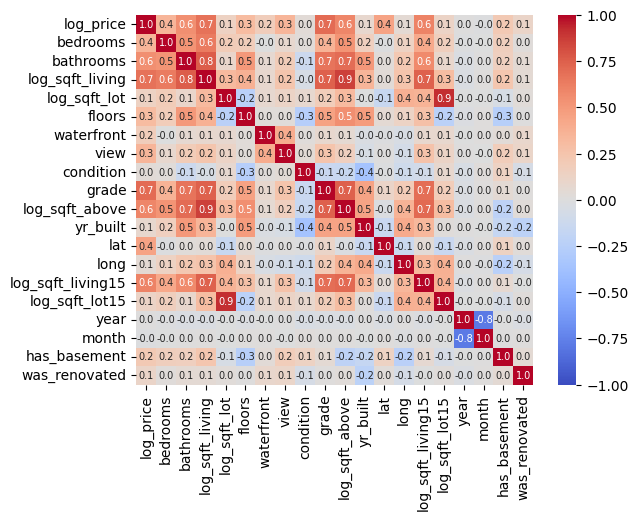

In [ ]:
sns.heatmap(df_prep.corr(), cmap="coolwarm", annot=True, fmt=".1f", vmin=-1, vmax=1, annot_kws={"fontsize": 7});

In [ ]:
features = df_prep.drop("log_price", axis=1)
labels = df_prep["log_price"]

In [ ]:
# Se decide remover las variables "log_sqft_living", "year", "log_sqft_lot" por su alta correlación
features_drop = features.drop(["log_sqft_living", "year", "log_sqft_lot"], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features_drop, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# CÓDIGO DEL MODELAMIENTO
---

In [ ]:
def evaluate_and_log_model(model, model_name, X_train, X_test, y_train, y_test, exp):
    with mlflow.start_run(experiment_id=exp, run_name=model_name):
        # Entrenar modelo
        model.fit(X_train, y_train)
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        y_test_true = np.expm1(y_test)

        # Computar métricas
        mae = mean_absolute_error(y_test_true, y_pred)
        rmse = root_mean_squared_error(y_test_true, y_pred)
        mse = mean_squared_error(y_test_true, y_pred)
        r2 = r2_score(y_test_true, y_pred)

        # Registrar parámetros
        params = model.get_params()
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Registrar métricas
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)

        # Registrar modelo
        if isinstance(model, XGBRegressor):
            mlflow.xgboost.log_model(model, "model", input_example=X_train)
        else:
            mlflow.sklearn.log_model(model, "model", input_example=X_train)

        # Imprimir resultados
        print(f"\nModelo: {model_name}")
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")

In [ ]:
# Crear experimento
exp = mlflow.create_experiment("KC_House_MLflow_Regression")

In [ ]:
# Ejecutar modelo baseline
model = LinearRegression()
evaluate_and_log_model(model, "LinearRegression (Baseline model)", X_train, X_test, y_train, y_test, exp)

2025/07/18 04:26:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Modelo: LinearRegression (Baseline model)
MAE: 106937.11, RMSE: 175858.14, MSE: 30926084016.41, R2: 0.76
🏃 View run LinearRegression (Baseline model) at: http://localhost:5000/#/experiments/1/runs/09a1362c00ba4650967c4e7612869f3d
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [ ]:
# Modelos a evaluar
models = [
    ("Ridge(alpha=1.0)", Ridge(alpha=1.0)),
    ("Lasso(alpha=0.1)", Lasso(alpha=0.1)),
    ("RandomForest(n=100, depth=20)", RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)),
    ("XGBoost(n=100, depth=6)", XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
]

# Ejecutar modelos
for model_name, model in models:
    evaluate_and_log_model(model, model_name, X_train, X_test, y_train, y_test, exp)

2025/07/18 04:26:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Modelo: Ridge(alpha=1.0)
MAE: 106932.97, RMSE: 175964.08, MSE: 30963358534.15, R2: 0.76
🏃 View run Ridge(alpha=1.0) at: http://localhost:5000/#/experiments/1/runs/a25ceb7c0b7b40998832f6dc00ef33f3
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/07/18 04:26:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Modelo: Lasso(alpha=0.1)
MAE: 151558.86, RMSE: 265257.91, MSE: 70361760446.18, R2: 0.46
🏃 View run Lasso(alpha=0.1) at: http://localhost:5000/#/experiments/1/runs/6930f9da3c414106a4eb8adbd88c51a2
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/07/18 04:26:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Modelo: RandomForest(n=100, depth=20)
MAE: 70667.73, RMSE: 142127.80, MSE: 20200311155.12, R2: 0.85
🏃 View run RandomForest(n=100, depth=20) at: http://localhost:5000/#/experiments/1/runs/3b486de397b646fa9e29ab19bcabf250
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/07/18 04:26:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:26:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving mode


Modelo: XGBoost(n=100, depth=6)
MAE: 68003.56, RMSE: 130653.69, MSE: 17070387076.30, R2: 0.87
🏃 View run XGBoost(n=100, depth=6) at: http://localhost:5000/#/experiments/1/runs/835cca1e95c340698d0a740eef7d1ebc
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [ ]:
# Espacio de hiperparámetros
param_dist = {
    "n_estimators": randint(100, 300),
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 5),
}

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Usamos RandomizedSearchCV para la búsqueda
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    verbose=1,
    scoring="neg_mean_squared_error",
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

# Evaluación y registro del mejor modelo
evaluate_and_log_model(
    model=best_model,
    model_name="XGBRegressor_Final",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    exp=exp
)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


2025/07/18 04:28:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:28:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving mode


Modelo: XGBRegressor_Final
MAE: 64862.27, RMSE: 123755.52, MSE: 15315429763.89, R2: 0.88
🏃 View run XGBRegressor_Final at: http://localhost:5000/#/experiments/1/runs/5589ef1584d0401bb0c96d94af42be8c
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [ ]:
# Se observan los hiperparámetros del mejor modelo
pd.Series(best_model.get_params())

,0
objective,reg:squarederror
base_score,None
booster,None
callbacks,None
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,0.859076
device,None
early_stopping_rounds,None
enable_categorical,False
